# Load in the data and normalise

This takes a while so I add print statements to show when it's done...

In [1]:
! ls *.csv

nmi_data_20181029__weekdays.csv  weekday_groupby_means.csv
nmi_data_20181029__weekends.csv  weekend_groupby_means.csv


In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

numeric_columns = [f'ekw{i+1}' for i in range(48)]

scaler = MinMaxScaler()

weekends_df = pd.read_csv('weekend_groupby_means.csv', index_col='nmi_uuid')
weekdays_df = pd.read_csv('weekday_groupby_means.csv', index_col='nmi_uuid')

weekends_df[numeric_columns] = scaler.fit_transform(
                                    weekends_df[numeric_columns].transpose()
                                ).transpose()

weekdays_df[numeric_columns] = scaler.fit_transform(
                                    weekdays_df[numeric_columns].transpose()
                                ).transpose()

print('Data is normalised and ready to be processed')

Data is normalised and ready to be processed


# Combine weekends/weekdays for each user

We want to combine weekends and weekdays so we have 96 columns instead of 48.

In [33]:
df = pd.concat([weekends_df, weekdays_df], axis=1)
df.columns = [f'ekw{i+1}' for i in range(96)]

df.to_csv('full_normalised_dataset.csv')

/home/sarmadtarar/anaconda3/envs/dask-ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


# Sanity check

I just wanted to make sure that the `pd.concat` uses the index of the dataframe to concatenate. Turns out, it definitely does!

In [32]:
nmi_uuid = '0000687e-c6d9-45b5-abe2-17d0219b0f6d'
print(weekends_df.loc[nmi_uuid, [f'ekw{i+1}' for i in range(10)]])
print(weekdays_df.loc[nmi_uuid, [f'ekw{i+1}' for i in range(38, 48)]])

ekw1     0.112121
ekw2     0.110759
ekw3     0.111765
ekw4     0.127469
ekw5     0.125122
ekw6     0.117060
ekw7     0.127186
ekw8     0.139270
ekw9     0.138890
ekw10    0.133582
Name: 0000687e-c6d9-45b5-abe2-17d0219b0f6d, dtype: float64
ekw39    0.912533
ekw40    0.788633
ekw41    0.734752
ekw42    0.613136
ekw43    0.499496
ekw44    0.447984
ekw45    0.327364
ekw46    0.257198
ekw47    0.176364
ekw48    0.137568
Name: 0000687e-c6d9-45b5-abe2-17d0219b0f6d, dtype: float64


# Read dataset and run KMeans

TODO: Normalisation technique done by sklearn creates NaNs. This cell also removes the data. To fix this I'll need to go back and manually normalise.

In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

df = pd.read_csv('full_normalised_dataset.csv')

numeric_data = np.asarray(
    df[[f'ekw{i+1}' for i in range(96)]]
)

nans = np.any(np.isnan(numeric_data), axis=1)
numeric_data = numeric_data[~nans]

kmeans = KMeans(n_clusters=8).fit(numeric_data)

kmeans.cluster_centers_.shape

(8, 96)

# Visualise cluster centers

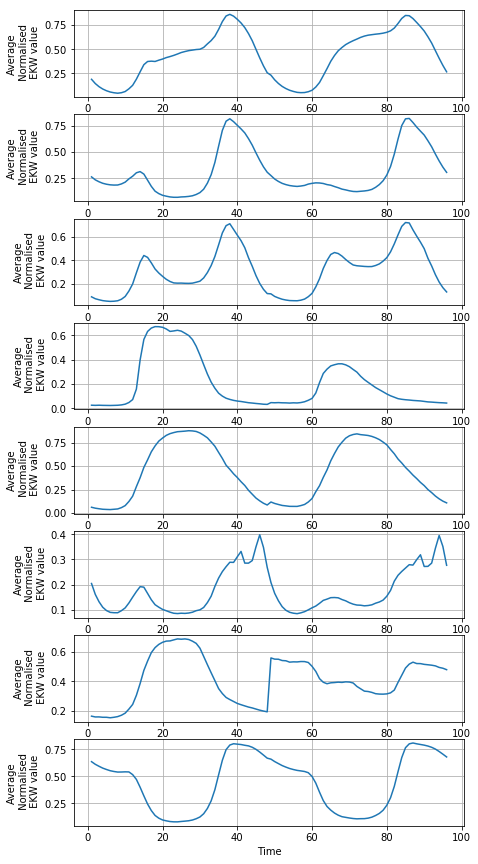

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(
    num='Cluster centres for each user\'s averaged, normalised weekend|weekday',
    figsize=(7, 15)
)

for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(range(1, 97), kmeans.cluster_centers_[i, :])
    plt.grid('on')
    plt.ylabel('Average\n Normalised\n EKW value')
    plt.xlabel('Time')
